In [1]:
import numpy as np
from matplotlib import pyplot

In [22]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
import sys
sys.path.append('../')

from track1_baseline_faiss.parse_results import parse_result_file, find_latest_version

# with run logs

Here we compare the QPS for the single machine with 1B vectors setting and the 2 machines with 500M setting.

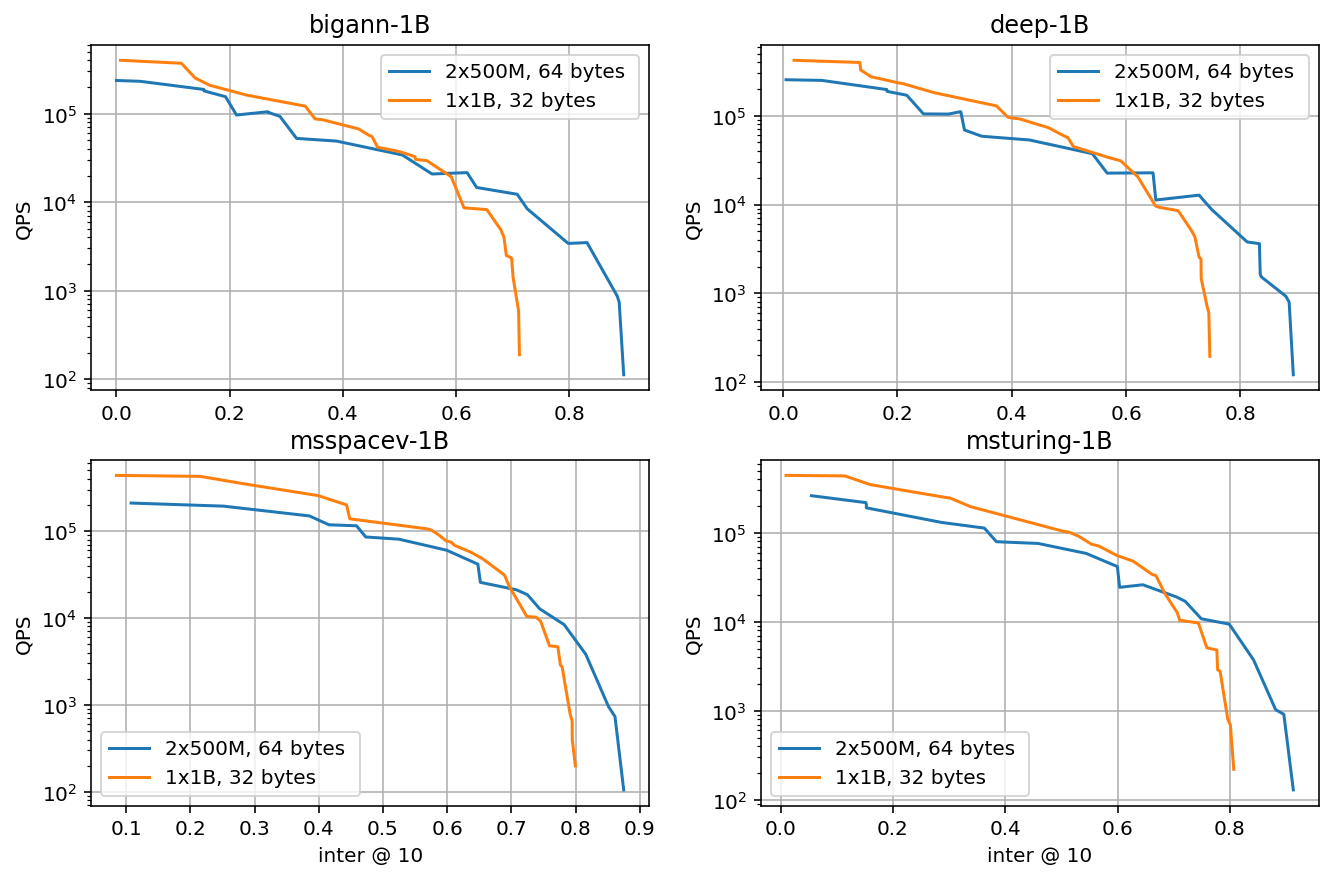

In [54]:
di = 0
pyplot.gcf().set_size_inches(11, 7)
for dsname in "bigann-1B deep-1B msspacev-1B msturing-1B".split():
    
    di += 1
    pyplot.subplot(2, 2, di)
    
    # the PQ 4-bit code does not expose enough statistics to do this computation
    for t in "PQ8bit", : # "PQ4bit": 
        
        suf = "PQ64" if t == "PQ8bit" else "PQ128x4fsr"
    
        indexkey, res, keys, stats = parse_result_file(find_latest_version(
            f"../logs/{dsname}.IVF1M_2level_{suf}.b.log"))

        r10 = res[:, 0]

        # simulate QPS w/ 2 shards 
        t_per_q = res[:, 1]
        # coarse quantization time
        quant_time = t_per_q * res[:, 3] / 100 
        # half the time to scan inverted lists 
        simulated_t = (t_per_q - quant_time) * 0.5 + quant_time

        qps = 1000 / simulated_t 

        pyplot.semilogy(r10, qps, label="2x500M, 64 bytes ")

        suf = "PQ32" if t == "PQ8bit" else "PQ64x4fsr"
        indexkey, res, keys, stats = parse_result_file(find_latest_version(
            f"../logs/{dsname}.IVF1M_2level_{suf}.b.log"))
                
        r10 = res[:, 0]
        # * 2 = we have two machines
        qps = 1000 / res[:, 1] * 2

        pyplot.semilogy(r10, qps, label="1x1B, 32 bytes")

    pyplot.title(dsname)
    if di >=3: 
        pyplot.xlabel("inter @ 10")
    pyplot.ylabel("QPS")
    pyplot.legend()
    pyplot.grid()
    # pyplot.show()